Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 23ms/step
Episode 2 finished after 20 tasks with reward: -1096.0
1/1 [==============================] - 0s 25ms/step
Episode 3 finished after 20 tasks with reward: -1096.0
1/1 [==============================] - 0s 25ms/step
Episode 4 finished after 20 tasks with reward: -1096.0
1/1 [==============================] - 0s 30ms/step
Episode 5 finished after 20 tasks with reward: -1096.0
1/1 [==============================] - 0s 27ms/step
Episode 6 finished after 20 tasks with reward: -1096.0
1/1 [==============================] - 0s 28ms/step
Episode 7 finished after 20 tasks with reward: -1096.0
1/1 [==============================] - 0s 26ms/step
Episode 8 finished after 20 tasks with reward: -1096.0
1/1 [==============================] - 0s 23ms/step
Episode 9 finished after 20 tasks with reward: -1096.0
1/1 [==============================] - 0s 35ms/step
Episode 10 finished after 20 tasks with r

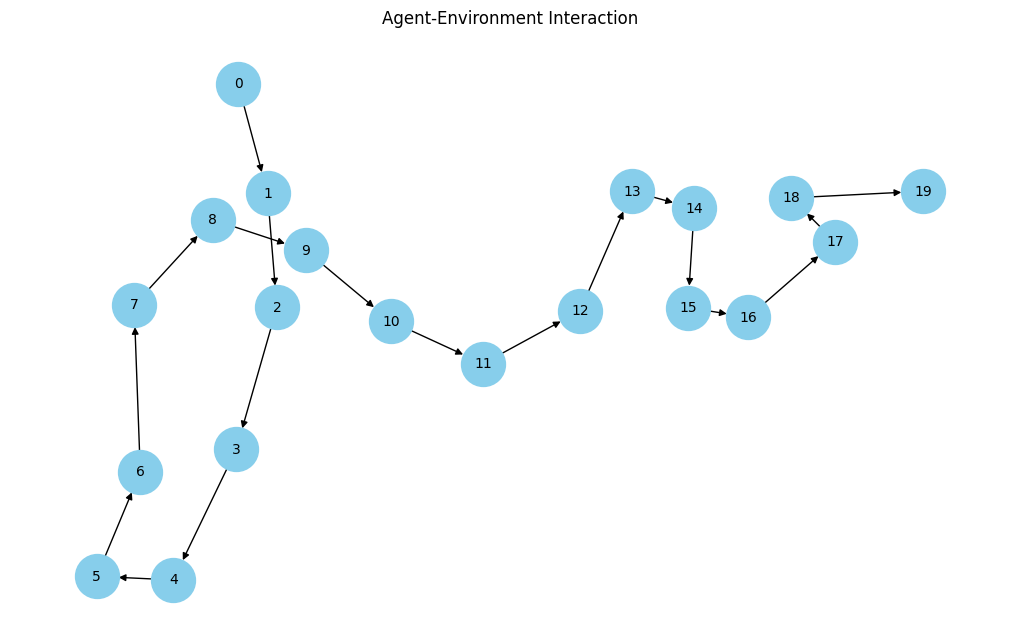

In [2]:
!pip install networkx
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import networkx as nx

# Define the environment parameters
num_nodes = 5
num_tasks = 20

class SchedulingEnvironment:
    def __init__(self):
        self.nodes = np.zeros(num_nodes)  # Available resources on each node
        self.tasks = np.random.randint(1, 10, size=num_tasks)  # Resource requirements of tasks
        self.current_task = 0

    def reset(self):
        self.nodes = np.zeros(num_nodes)
        self.current_task = 0
        return self.nodes #Return the initial state directly

    def step(self, action):
        # Execute the chosen action (assign task to node)
        task = self.tasks[self.current_task]
        self.nodes[action] += task
        self.current_task += 1

        # Calculate reward and check if the episode is done
        reward = -np.sum(self.nodes)  # Negative of total utilization
        done = self.current_task == num_tasks

        return self.nodes, reward, done

# DQN Agent
class DQNAgent:
  def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.batch_size = 16
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.997
        self.epsilon_min = 0.02
        self.model = self.build_model()

  def build_model(self):
    model = Sequential()
    model.add(Dense(8, input_dim=self.state_size, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(self.action_size, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))  # Use learning_rate parameter
    return model


  def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

  # def choose_action(self, state):
  #       if np.random.rand() <= self.epsilon:
  #           return env.action_space.sample()
  #       q_values = self.model.predict(state)
  #       return np.argmax(q_values[0])

  def choose_action(self, state):
    if np.random.rand() <= self.epsilon:
        return np.random.choice(self.action_size)  # Random action
    # q_values = self.model.predict(state)
    q_values = self.model.predict(state.reshape(1, -1))
    return np.argmax(q_values[0])  # Greedy action


  def replay(self):
    if len(self.memory) < self.batch_size:
        return
    minibatch = random.sample(self.memory, self.batch_size)
    for state, action, reward, next_state, done in minibatch:
        target = reward
        if not done:
            target = reward + self.gamma * np.amax(self.model.predict(np.reshape(next_state, (1, self.state_size)))[0])
        # target_q = self.model.predict(np.reshape(state, (1, self.state_size)))
        target_q = self.model.predict(state[np.newaxis, :])
        target_q[0][action] = target
        # self.model.fit(np.reshape(state, (1, self.state_size)), target_q, epochs=1, verbose=0)
        self.model.fit(state[np.newaxis, :], target_q, epochs=1, verbose=0)
    if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay

  def visualize_network(self):
        tf.keras.utils.plot_model(self.model, show_shapes=True, show_layer_names=True)

    # ... (Same as in your initial code with appropriate modifications)

def main_dqn():
  if __name__ == '__main__':
    env = SchedulingEnvironment()
    state_size = num_nodes
    action_size = num_nodes

    agent = DQNAgent(state_size, action_size)
    num_episodes = 10

    #Creating the directed graph for visualizing the interaction
    G = nx.DiGraph()
    plt.figure(figsize=(10, 6))
    episode_subgraph = nx.DiGraph()


    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0

        episode_subgraph.clear() # clear the subgraph at the beginning

        #creating a new episode subgraph for visualization
        # epsode_subgraph = nx.DiGraph()

        for time_step in range(num_tasks):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            episode_reward += reward
            # state = next_state

            # Add nodes and edges to the episode subgraph
            episode_subgraph.add_node(time_step, label=f'Task {time_step+1}\nReward: {reward:.2f}')
            if time_step > 0:
              episode_subgraph.add_edge(time_step - 1, time_step)

            state = next_state

            if done:
                print(f"Episode {episode + 1} finished after {time_step + 1} tasks with reward: {episode_reward}")
                break

            agent.replay()


        # Add the episode subgraph to the main interaction graph
        G = nx.compose(G, episode_subgraph)

    # Visualize the interaction graph
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=1000, font_size=10, node_color='skyblue', font_color='black')
    plt.title("Agent-Environment Interaction")
    plt.show()

    # Visualize the agent's network layers
    agent.visualize_network()

if __name__ == '__main__':
    main_dqn()
